*updated 08 Aug 2025, Julian Mak (whatever with copyright, do what you want with this)

### As part of material for OCES 4303 "AI and Machine Learning in Marine Science" delivered at HKUST

For the latest version of the material, go to the public facing [GitHub](https://github.com/julianmak/OCES4303_ML_ocean) page.

---
# 6. Decision trees

An example of a ***decision tree*** is as below:

<img src="https://i.imgur.com/UayMNei.png" width="450" alt='cat decision tree'>

From a manual point of view it's not too hard to see how we create decision trees, but how would a machine do this? The goal of this notebook is to spend a bit of time introducing some concepts behind how a single decision tree is created, and how you might use these as classifiers and/or regressors. This sets the scene for the next notebook: ***random forest*** and ***gradient boosting*** approaches are effective an ensemble of trees.

> ## Key Objective(s)
> 1. Go into a little detail about the anatomy of decision trees, and how trees are created by the machine (need a bit of probability here)
> 2. Consider an example of decision tree as a classifier and a regressor
> 3. Some procedures to prevent over-fitting (e.g. pruning)

We are going to admire this picture of a tree for a bit, then load some packages and go through some details relating to how decision trees are created. For this notebook I am going to use the penguins data for the whole way (it's actually easier to make my points with it).

<img src="https://i.imgur.com/2MeMlCK.jpeg" width="450" alt='broc-collie'>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler

# load the penguin data
option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "penguins.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES4303_ML_ocean/refs/heads/main/penguins.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(path)

loading data remotely


---
## a) Some background

### Anatomy of a decision tree

Going to introduce some terminology so I can use it later:

* Root: This would be the start of the tree (the "is that for me?" box above)
* Leaves: The things at the end (the "I don't want it" and "That's for me" box above)
* Node: The intermediate blocks connecting the root to the leaves (in this case strictly speaking there isn't one; leaves can be pure nodes with no subsequent connectors)
* Branches: The connectors detailing the decisions (here it really should be the "yes" and "no")
* Levels/depth: Distance from the node and maximum number of levels (I would call above depth 1, arguably it could be 2)
* Parent/child: Usually refer to nodes that are directly connected. If a tree is going down like the above, the parent node would be the higher one (at a *lower* level; here the root node is the parent and the leaves are the child nodes)

### Recap in probability, and the concept of information entropy

(I want to spend a bit of time on this because similar ideas crop out when talking about Neural Networks.)

Recall that a ***probability*** $p_i$ is a value between 0 to 1 assigned to an event $X_i$ occuring, with the condition that the sum of all probabilities should be 1, i.e. $\sum p_i = 1$. With the penguin data, this might be the probability of me randomly picking a sample out of the full dataset and the chances of me picking `Adelie`, `Chinstrap` or `Gentoo`. I am going to assume the process of drawing a sample is fair (i.e. follows a uniform distribution), then the probabilities are simply the number of samples of $X_i$ divided by the total sample size $N$. Let's actually do that in code form (because I want to use the result later).

In [2]:
# calculate the probability of drawing a particular species

# pandas can actually do this in one go
freq = df["species"].value_counts()
p = df["species"].value_counts(normalize=True)  # pandas can actually do this in one go

print(freq)
print(f"total number of samples = {np.sum(freq)}")
print(" ")
print(p)
print(f"total probability = {np.sum(p)}")
print(" ")

species
Adelie       151
Gentoo       123
Chinstrap     68
Name: count, dtype: int64
total number of samples = 342
 
species
Adelie       0.441520
Gentoo       0.359649
Chinstrap    0.198830
Name: proportion, dtype: float64
total probability = 1.0
 


Thing to notice for later is that the dataset is unbalanced, with fewer samples in `Chinstrap`.

If instead you want to find the probability in picking out a continuous variable like `bdoy_mass_g`, then it doesn't make sense to talk about a probability of picking out a sample that has 4000 g, because it is almost surely not going to happen. Instead you talk about the probability of picking out a sample between (say) 3900 and 4100 g, i.e. you create ***bins*** or categories for the data to fall into, and then you proceed as before. This is of course just the same as creating a histogram, and in this case it is the area of the histogram (or pdf) that should sum (or integrate) to 1.

A quantity of interest is called the ***information entropy*** or the ***Shannon entropy***, defined as
\begin{equation*}
    H = \sum_{i=0}^N H_i = -\sum_{i=0}^N p_i \log_a p_i,
\end{equation*}
where I have not been very specific about the choice of base $a$. The original definition uses $a=2$, although $a=10$ and $a=e$ (so $\log \to \ln$) will also work.

> NOTE: It doesn't really matter because almost all the time it's the "shape" or functional behaviour of $H$ that is of importance, rather than it's value. I am actually going to use the natural log (i.e. $a=e$), and I am simply going to denote that $\log$ (rather than use $\ln$). You can call the related logs in `numpy` via `np.log2`, `np.log10` and `np.log`.

This quantity shows up in ecology as the Shannon index and is supposed to be a measure of species diversity. The way you may want to think about entropy is the amount of surprise or information you get from doing a random sample from the dataset: $H=0$ is no surprise and perfect information, while high $H$ means the converse. To see this, consider the two extremes:

* If there is only one species, so $p_0 = 1$ by construction, but $\log 1 = 0$ for any base, so $H = 0$. Drawing a sample here provides zero surprise and information, because you can't get any other possibility anyway (at least for this category).
* Convince yourself that $H$ is maximised for a uniform distribution, in which case $p_i = 1/(N+1)$, so $\log 1/(N+1) = \log 1 - \log (N+1) = -\log(N+1)$ for any base, so $H = (N+1)/(N+1)\times \log(N+1) = \log(N+1)$. Diversity is thus maximum, and drawing a sample is maximally surprising because there is no bias in the dataset.

The penguins data is not balanced so we could calculate the Shannon index for it (although I am using the wrong base on purpose).

In [3]:
# shannon index for all penguin data based on species

H = (-p * np.log(p)).sum()
print(f"H = {H:.6f} in base e")

# pick out number of unique entries
num_unique = len(df["species"].unique())
print(f"maximum possible Shannon entropy = {np.log(num_unique):.6f}")
print(" ")

H = 1.049915 in base e
maximum possible Shannon entropy = 1.098612
 


We can play the same game for continuous data; going to do this for the case `body_mass_g` feature as it serves to be an intermediate step to the next part in terms of some `pandas` syntax. The first part shows which bins it's actually going to dump the data in, and the second does the binning and computation of the probabilities, then entropy.

In [4]:
# cut the data and return bins
out = pd.cut(df["body_mass_g"], 5)
bins = out.unique()  # find the number of unique entries based on intervals
print(out.value_counts())
print(" ")

p = out.value_counts(normalize=True)
H = (-p * np.log(p)).sum()
print(f"H = {H:.6f} in base e")

# pick out number of unique entries
num_unique = len(bins)
print(f"maximum possible Shannon entropy = {np.log(num_unique):.6f}")
print(" ")

body_mass_g
(3420.0, 4140.0]    124
(4140.0, 4860.0]     83
(2696.4, 3420.0]     58
(4860.0, 5580.0]     55
(5580.0, 6300.0]     22
Name: count, dtype: int64
 
H = 1.482791 in base e
maximum possible Shannon entropy = 1.609438
 


### Information gain

So the value of the entropy by itself is neither here nor there. The question to ask here is that suppose I already chose a feature to segment the data (say `species`), then given a choice of choosing the next feature to segment data on, which one should I choose? One way to do this is to choose the feature that gives you the maximum ***information gain***: if high entropy is low information, I want to choose the feature that lowers the resulting entropy as much as possible. Information gain is calculated as
\begin{equation*}
    \mbox{IG} = H_p - \sum_{i=0}^N p_{c,i} H_{c,i},
\end{equation*}
where $H_p$ is the entropy of the parent class, and $p_c$ and $H_c$ are the probabilities and entropy associated with the child classes. 

> NOTE: IG can be written in terms of the ***Kullback-Liebler*** (KL) divergence, which is an important concept in information geometry and used quite widely in ML. Not going to elaborate on what that is though; think of it as a distance between pdfs.

Probably easier to explain with an example:

1. If we take `species` as the parent feature, then we already calculated $H_p$ once above.
2. If I take `body_mass_g` as the child feature to further segment on, then I need to bin the data accordingly (also done above).
3. Find the number of `species` in those `body_mass_g` bins, and compute the occurrences and entropies accordingly. The below does this by creating the bins, finding the indices corresponding to the unique bins, pick out the data, and then computing the entropies.

In [5]:
# computing IG

# compute entropy of parent first
p = df["species"].value_counts(normalize=True)
H = (-p * np.log(p)).sum()

# compute intermediate variables
out = pd.cut(df["body_mass_g"], 5)
bins = out.unique()

H_i, n_i = np.zeros(len(bins)), np.zeros(len(bins))  # using n later to compute p_i
for i in range(len(bins)):
    ind = (out == bins[i])
    n_i[i] = df[ind]["species"].value_counts().sum()
    p_i = df[ind]["species"].value_counts(normalize=True)
    H_i[i] = (-p_i * np.log(p_i)).sum()

# compute information gain
IG = H - np.sum(H_i * n_i / np.sum(n_i))  # n_i / sum(n_i) = p_i
print(f"IG(parent = species, child = body_mass_g) = {IG:.6f}")
print(" ")

IG(parent = species, child = body_mass_g) = 0.460433
 


Positive IG here means the entropy is being reduced, which is expected. We should then check this for all features.

In [6]:
# compute IGs

# compute entropy of parent first
p = df["species"].value_counts(normalize=True)
H = (-p * np.log(p)).sum()

feature_names = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]

for child_feature in feature_names:

    # compute intermediate variables
    out = pd.cut(df[child_feature], 5)
    bins = out.unique()

    H_i, n_i = np.zeros(len(bins)), np.zeros(len(bins))  # using n later to compute p_i
    for i in range(len(bins)):
        ind = (out == bins[i])
        n_i[i] = df[ind]["species"].value_counts().sum()
        p_i = df[ind]["species"].value_counts(normalize=True)
        H_i[i] = (-p_i * np.log(p_i)).sum()
    
    # compute information gain
    IG = H - np.sum(H_i * n_i / np.sum(n_i))
    print(f"IG(parent = species, child = {child_feature:<17}) = {IG:.6f}")
    
print(" ")

IG(parent = species, child = bill_length_mm   ) = 0.521951
IG(parent = species, child = bill_depth_mm    ) = 0.508796
IG(parent = species, child = flipper_length_mm) = 0.602198
IG(parent = species, child = body_mass_g      ) = 0.460433
 


Note that the IG is the largest for `flipper_length_mm`, i.e. it's reducing the entropy the most. It is then suggesting that, given we chose `species` as a parent, we probably want to segment next on `flipper_length_mm`. Thus this is one measure on how the entropy can guide the creation of branches and leaves in decision trees.

> NOTE: This is all relative and ordering matters: choosing `flipper_length_mm` as parent feature then `species` as child feature will not give the same IG.
>
> <span style="color:red">Q.</span> Modify code accordingly to include both continuous and discrete labels as parent/child features to come for the IG. I would do the continuous ones first before I do the discrete ones; you probably need to convert the labels to numerical values first, and then dump that into the `df` as part of a `pandas` dataframe so you can use the subroutines above.

To close, there is a similar quantity to the information entropy called the ***Gini index*** or ***Gini impurity***, which instead has the form 
\begin{equation*}
    G = \sum_i p_i(1 - p_i).
\end{equation*}
The Gini index measures "impurities" in the dataset: the case with a single feature would have $p_i = 1$, so $G = 0$ and is completely "pure", and corresponds also to the $H=0$ case. $G=1$ would be the maximally mixed case. Both can be used to constructu something like an information gain measure like the above, although the Gini index is more computationally efficient for binary decisions such as the trees we are considering. Information entropy and related ideas have more links with neural networks (hence me spending more time on that).

---
## b) Trees as classifiers

So for classifiers we are going to take target $Y$ to the `species` feature. Going to load a whole load of things and to demonstrate some features that one could dig into.

In [7]:
from sklearn.tree import DecisionTreeClassifier

feature_names = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
X = df[feature_names].values
X = StandardScaler().fit_transform(X)

encoder = LabelEncoder()
Y = encoder.fit_transform(df["species"])

# withhold 20% of data that model training does not see, and use that to test skill
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=4167)

Going to fit a deliberately shallow tree (by specifying `max_depth=2`), and force it to use the information entropy criterion with `criterion="entropy"`. I am also going to query the feature importance in the fitted model with `model.feature_importances_`.

> NOTE: I am overriding the defaults are `max_depth=None` and `criterion="gini"`.

In [8]:
# fit a decision tree (deliberately shallow for showing)
model = DecisionTreeClassifier(max_depth=2, criterion="entropy")
model.fit(X_train, Y_train)

# basic skill diagnostics
Y_pred = model.predict(X_test)
N = len(Y_test)
skill_all = np.sum(Y_pred == Y_test)
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
print(f"fitted feature importance [1 = max]:")
for i in range(len(feature_names)):
    print(f"    {feature_names[i]:<20} = {model.feature_importances_[i]:.4f}")
print(" ")

overall skill: 66 correct out of 69 (95.65%)
fitted feature importance [1 = max]:
    bill_length_mm       = 0.2909
    bill_depth_mm        = 0.0904
    flipper_length_mm    = 0.6187
    body_mass_g          = 0.0000
 


The model does pretty well on the testing dataset. It also seems to be finding that `flipper_length_mm` is the most important feature, which is potentially consistent with our IG calculation above. 

Note also particular (on mine at least) it doesn't actually use the `body_mass_g` feature at all, because the `body_mass_g` has zero feature importance. This is partly because I forced `max_depth=2` (so I can't have that much complexity anyway), and it basically managed to classify all the data with three features. This would be an early termination criterion: if all data is accounted for, stop any further creation of nodes.

> <span style="color:red">Q.</span> Why am I only using "potentially"? What is wrong with my assertion/statement here? (How is IG defined?)
>
> <span style="color:red">Q.</span> Convince yourself that for this case it doesn't matter really if I scale the data or not. In other words, decision trees are ***scale-invariant*** (but I am still scaling because it possibly lessens the computational burden a bit).

The thing with decision trees (and somewhat unlike most neural networks) you could actually look at the tree that gets formed, and is arguably interpretable, although of course if your model is sufficiently complex that may be a mute point anyway. In the above I deliberately forced the tree to be simple so the display coming up is a bit easier to see. I can use `plot_tree` to actually plot a figure, and `export_text` to spit out the entries in the decision tree.

> NOTE: I passed in the `features_names=` argument so that it would display the feature names, otherwise it would display $X[2]$ etc., which refers to the third feature (in this case because python counts from zero), which is `flipper_length_mm`.
>
> The colours in the trees denote the classes, as can be seen from the text description of the tree.

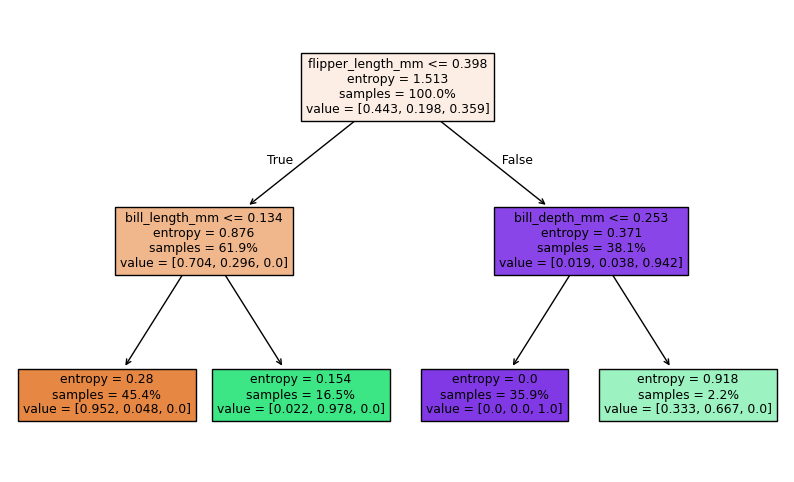

In [9]:
from sklearn.tree import plot_tree, export_text

fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
plot_tree(model, filled=True, proportion=True, feature_names=feature_names);

In [10]:
# export as text
print(export_text(model, feature_names=feature_names))
print(" ")

|--- flipper_length_mm <= 0.40
|   |--- bill_length_mm <= 0.13
|   |   |--- class: 0
|   |--- bill_length_mm >  0.13
|   |   |--- class: 1
|--- flipper_length_mm >  0.40
|   |--- bill_depth_mm <= 0.25
|   |   |--- class: 2
|   |--- bill_depth_mm >  0.25
|   |   |--- class: 1

 


If we do not force the maximum depth then we get the following.

overall skill: 65 correct out of 69 (94.20%)
fitted feature importance [1 = max]:
    bill_length_mm       = 0.3176
    bill_depth_mm        = 0.0891
    flipper_length_mm    = 0.5481
    body_mass_g          = 0.0452
 
|--- flipper_length_mm <= 0.40
|   |--- bill_length_mm <= 0.13
|   |   |--- bill_length_mm <= -0.29
|   |   |   |--- bill_depth_mm <= -0.25
|   |   |   |   |--- bill_length_mm <= -0.81
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- bill_length_mm >  -0.81
|   |   |   |   |   |--- class: 1
|   |   |   |--- bill_depth_mm >  -0.25
|   |   |   |   |--- class: 0
|   |   |--- bill_length_mm >  -0.29
|   |   |   |--- body_mass_g <= -0.45
|   |   |   |   |--- class: 1
|   |   |   |--- body_mass_g >  -0.45
|   |   |   |   |--- class: 0
|   |--- bill_length_mm >  0.13
|   |   |--- body_mass_g <= 0.47
|   |   |   |--- class: 1
|   |   |--- body_mass_g >  0.47
|   |   |   |--- class: 0
|--- flipper_length_mm >  0.40
|   |--- bill_depth_mm <= 0.25
|   |   |--- class: 2
|   |

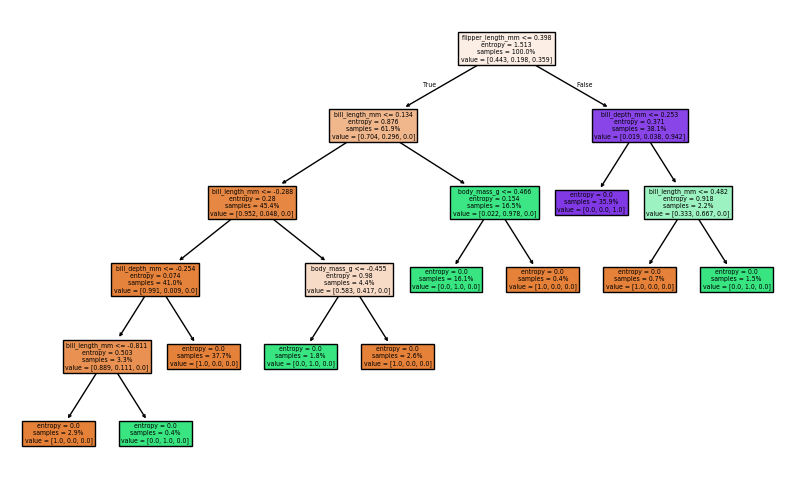

In [11]:
# fit a decision tree (deliberately shallow for showing)
model = DecisionTreeClassifier(criterion="entropy")
model.fit(X_train, Y_train)

# basic skill diagnostics
Y_pred = model.predict(X_test)
N = len(Y_test)
skill_all = np.sum(Y_pred == Y_test)
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
print(f"fitted feature importance [1 = max]:")
for i in range(len(feature_names)):
    print(f"    {feature_names[i]:<20} = {model.feature_importances_[i]:.4f}")
print(" ")

print(export_text(model, feature_names=feature_names))
print(" ")

fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
plot_tree(model, filled=True, proportion=True, feature_names=feature_names);

Note in this case class 2 (which is `Gentoo`) has a termination node that is quite high up on the tree close to the root node. If you remember this is consistent with our observations that `Gentoo` data seems to live in a slightly different part of the feature space compared to the other two classes.

### Decision boundaries

We can plot out the decision boundaries easily if we only models using two features. Below takes three specific combinations just to demonstrate what these look like.

> NOTE: Note I've standardised the data so the units are not quite right.

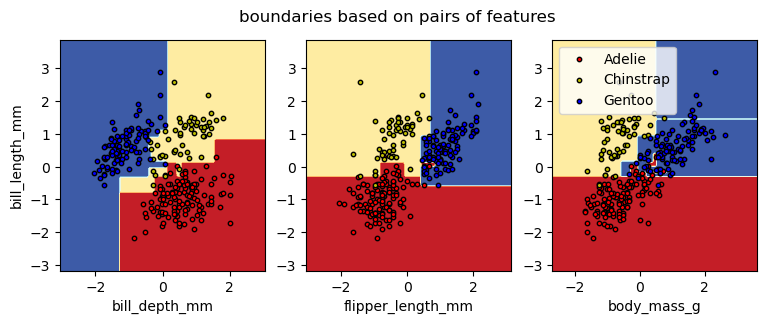

In [12]:
# visualise the decision boundary
from sklearn.inspection import DecisionBoundaryDisplay

combos = [[1, 0], [2, 0], [3, 0]]  # pre-define some pairs of features
colors = "ryb"  # red yellow blue

fig = plt.figure(figsize=(9, 3))

for i in range(3):
    # train a new model per cycle
    model = DecisionTreeClassifier().fit(X_train[:, combos[i]], Y_train)
    
    ax = plt.subplot(1, 3, i+1)
    DecisionBoundaryDisplay.from_estimator(
        model,
        X_train[:, combos[i]],
        cmap=plt.cm.RdYlBu,
        response_method="predict",
        ax=ax
        )
    # plot the actual data points in
    for j in range(3): # 3 species
        idx = np.where(Y_train == j)
        ax.scatter(X_train[idx, combos[i][0]], X_train[idx, combos[i][1]], 
                   c=colors[j], edgecolor="k", s=10, label=f"{encoder.classes_[j]}")
    ax.set_xlabel(f"{feature_names[i+1]}")
    if i == 0:
        ax.set_ylabel(f"{feature_names[0]}")
ax.legend()

fig.suptitle(r"boundaries based on pairs of features");

### Dependence on `max_depth`

If we don't specify `max_depth` then the trees goes on until the leave nodes are "pure", so either entropy or Gini index is zero. It is sometimes a good idea to limit `max_depth` as a control to possiblities of over-fitting. Below code changes that parameter to see how the skill varies as a function of `max_depth`.

In [13]:
# dependence of skill with varying max_depth

for max_depth in range(1, 6):
    # fit a decision tree with fixed seed
    model = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth, random_state=167)
    model.fit(X_train, Y_train)

    # basic skill diagnostics
    Y_pred = model.predict(X_test)
    N = len(Y_test)
    skill_all = np.sum(Y_pred == Y_test)
    print(f"max_depth = {max_depth} overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
    print(f"fitted feature importance [1 = max]:")
    for i in range(len(feature_names)):
        print(f"    {feature_names[i]:<20} = {model.feature_importances_[i]:.4f}")
print(" ")

max_depth = 1 overall skill: 54 correct out of 69 (78.26%)
fitted feature importance [1 = max]:
    bill_length_mm       = 0.0000
    bill_depth_mm        = 0.0000
    flipper_length_mm    = 1.0000
    body_mass_g          = 0.0000
max_depth = 2 overall skill: 66 correct out of 69 (95.65%)
fitted feature importance [1 = max]:
    bill_length_mm       = 0.2909
    bill_depth_mm        = 0.0904
    flipper_length_mm    = 0.6187
    body_mass_g          = 0.0000
max_depth = 3 overall skill: 65 correct out of 69 (94.20%)
fitted feature importance [1 = max]:
    bill_length_mm       = 0.3082
    bill_depth_mm        = 0.0982
    flipper_length_mm    = 0.5760
    body_mass_g          = 0.0176
max_depth = 4 overall skill: 64 correct out of 69 (92.75%)
fitted feature importance [1 = max]:
    bill_length_mm       = 0.2965
    bill_depth_mm        = 0.1036
    flipper_length_mm    = 0.5542
    body_mass_g          = 0.0457
max_depth = 5 overall skill: 64 correct out of 69 (92.75%)
fitted featur

It looks like the model is reaching it's peak performance around `max_depth=2` or `max_depth=3`.

### Dependence on `criterion`

Below does the same as above but using the (default) Gini criterion instead. Performance ends up being about similar.

In [14]:
# dependence of skill with varying max_depth

for max_depth in range(1, 6):
    # fit a decision tree with fixed seed
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=167)
    model.fit(X_train, Y_train)

    # basic skill diagnostics
    Y_pred = model.predict(X_test)
    N = len(Y_test)
    skill_all = np.sum(Y_pred == Y_test)
    print(f"max_depth = {max_depth} overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
    print(f"fitted feature importance [1 = max]:")
    for i in range(len(feature_names)):
        print(f"    {feature_names[i]:<20} = {model.feature_importances_[i]:.4f}")
print(" ")

max_depth = 1 overall skill: 54 correct out of 69 (78.26%)
fitted feature importance [1 = max]:
    bill_length_mm       = 0.0000
    bill_depth_mm        = 0.0000
    flipper_length_mm    = 1.0000
    body_mass_g          = 0.0000
max_depth = 2 overall skill: 66 correct out of 69 (95.65%)
fitted feature importance [1 = max]:
    bill_length_mm       = 0.3622
    bill_depth_mm        = 0.0559
    flipper_length_mm    = 0.5819
    body_mass_g          = 0.0000
max_depth = 3 overall skill: 65 correct out of 69 (94.20%)
fitted feature importance [1 = max]:
    bill_length_mm       = 0.3660
    bill_depth_mm        = 0.0692
    flipper_length_mm    = 0.5530
    body_mass_g          = 0.0118
max_depth = 4 overall skill: 64 correct out of 69 (92.75%)
fitted feature importance [1 = max]:
    bill_length_mm       = 0.3531
    bill_depth_mm        = 0.0679
    flipper_length_mm    = 0.5336
    body_mass_g          = 0.0454
max_depth = 5 overall skill: 64 correct out of 69 (92.75%)
fitted featur

> <span style="color:red">Q.</span> There are a whole load of other parameters one could specify for decision trees (e.g. see [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)). Have a play around with those.
>
> <span style="color:red">Q.</span> I can think you pass further options into `plot_tree` to beautify it accordingly, have a look at doing that.

---
## c) Trees as regressors

Recall from that example in session 2 for penguins data encountered, shown below.

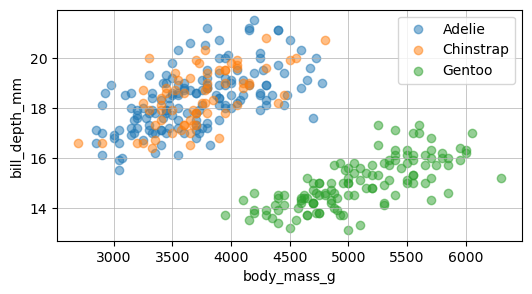

In [15]:
# do a 2d plot of two specific variables in the penguins data

target_vars = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
ind = [3, 1]

fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
for species in np.sort(df["species"].unique()): # pick out all unique entries under `species`
    ax.scatter(df[df["species"] == species][target_vars[ind[0]]], 
               df[df["species"] == species][target_vars[ind[1]]],
               label=species,
               alpha=0.5,  # fade this for demonstration later
               )
ax.set_xlabel(f"{target_vars[ind[0]]}")
ax.set_ylabel(f"{target_vars[ind[1]]}")
ax.grid(lw=0.5, zorder=0)
ax.legend();

So here if I do standard linear models on the full data it's pretty bad, because there are clearly clusters identified by the `species` feature, but you can't really put that information into those regression models. Here we explore the possibility of doing that with decision trees. Below loads the `DecisionTreeRegressor` object and defines the input and output data accordingly: noticed I changed my `X` and `Y`s, and I had to do some funny things to make sure the data has the right shapes.

> NOTE: The regressor now uses a different loss function, because the aim is slightly different now. The branching aspect is similar though.

In [16]:
from sklearn.tree import DecisionTreeRegressor

# standardise first but overwrite the inputs accordingly
feature_names = ["bill_depth_mm", "body_mass_g"]
X = StandardScaler().fit_transform(df[feature_names].values)

# define target first (want the 1st feature "flipper_length_mm" here)
Y = X[:, 0]

# define the species feature and then stack it with "body_mass_g"
encoder = LabelEncoder()
dummy = encoder.fit_transform(df["species"])
X = np.concatenate((X[:, 1].reshape(-1, 1), dummy.reshape(-1, 1)), axis=-1)

print(f"input X has shape = {X.shape}")
print(" ")

# withhold 20% of data that model training does not see, and use that to test skill
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=4167)

# fit a decision tree (deliberately shallow for showing)
model = DecisionTreeRegressor(max_depth=2, criterion="squared_error")
model.fit(X_train, Y_train);

input X has shape = (342, 2)
 


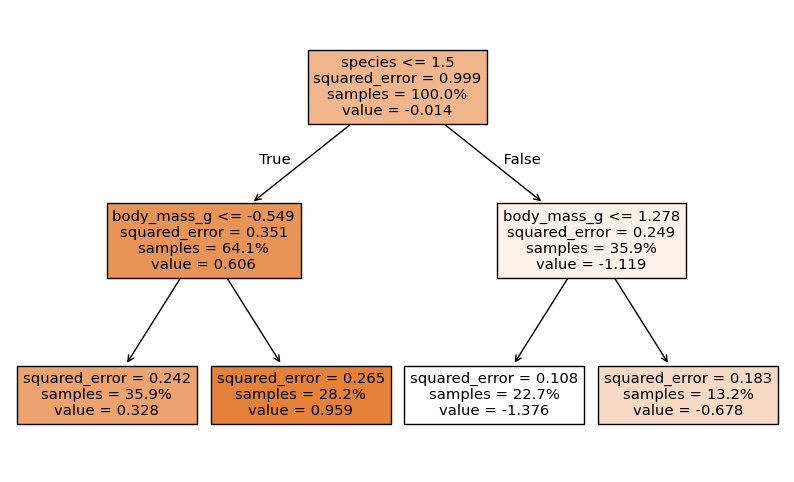

In [17]:
# plot out the tree
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
plot_tree(model, filled=True, proportion=True, feature_names=["body_mass_g", "species"]);

The model is deciding in this case it would like to split according to species first, which is not unexpected. We test for the skill below on the test dataset.

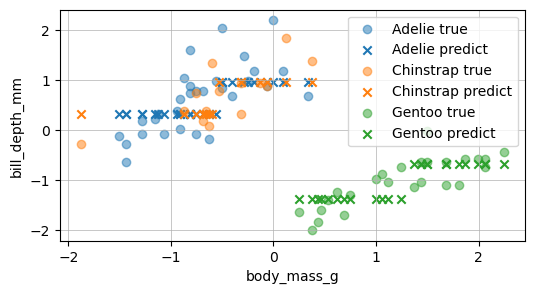

In [18]:
# do a prediction
Y_pred = model.predict(X_test)

fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
for j in range(len(encoder.classes_)):
    ax.scatter(X_test[X_test[:, 1]==j, 0], Y_test[X_test[:, 1]==j],
               label=f"{encoder.classes_[j]} true",
               color=f"C{j}",
               alpha=0.5,  # fade this for demonstration later
               )
    ax.scatter(X_test[X_test[:, 1]==j, 0], Y_pred[X_test[:, 1]==j],
               label=f"{encoder.classes_[j]} predict",
               color=f"C{j}",
               marker="x",
               )
ax.set_xlabel(f"{target_vars[ind[0]]}")
ax.set_ylabel(f"{target_vars[ind[1]]}")
ax.grid(lw=0.5, zorder=0)
ax.legend();

So in this case one single model is able to ingest the `species` feature to do regression. This is in contrast to the previous suggestion where you either use existing labels or create labels with clustering, then you train up a model depending on the number of labels. 

The predictions are not fantastic in this case and clearly piecewise constant, and that's because I've specified a small vaule of `max_depth` so I can show the decision tree. With increased `max_depth` it can be seen we recover variability in the dataset accordingly.

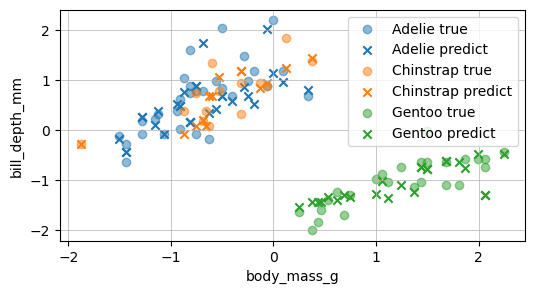

In [19]:
# no restriction on depth
model = DecisionTreeRegressor(criterion="squared_error")
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
for j in range(len(encoder.classes_)):
    ax.scatter(X_test[X_test[:, 1]==j, 0], Y_test[X_test[:, 1]==j],
               label=f"{encoder.classes_[j]} true",
               color=f"C{j}",
               alpha=0.5,  # fade this for demonstration later
               )
    ax.scatter(X_test[X_test[:, 1]==j, 0], Y_pred[X_test[:, 1]==j],
               label=f"{encoder.classes_[j]} predict",
               color=f"C{j}",
               marker="x",
               )
ax.set_xlabel(f"{target_vars[ind[0]]}")
ax.set_ylabel(f"{target_vars[ind[1]]}")
ax.grid(lw=0.5, zorder=0)
ax.legend();

### Pruning

Pruning refers to removing nodes accordingly. You do this with plants to keep the shape and/or not let the whole plant grow wildly. For the context here you want to do it as a way to control over-fitting by simplifying the tree. The measure of interest is that some kind of balance between skill and complexity (cf. AIC and BIC): you want to remove the nodes that contribute complexity but not so much in skill. The practical way of doing this would be to specify the `ccp_alpha` parameter to the tree initialisation. Below I consider the full depth case and compare a case with `ccp_alpha` zero and one with small. The things I am looking at particularly is the complexity of the resulting tree, which I can call from the `model` created.

> NOTE: Similar ideas are used in neural networks where nodes in the layers can be dropped accordingly.

full depth model has depth = 12 and 124 leaves
full depth model has MSE = 0.2649
pruned model has depth = 11 and 44 leaves
pruned model has MSE = 0.2628


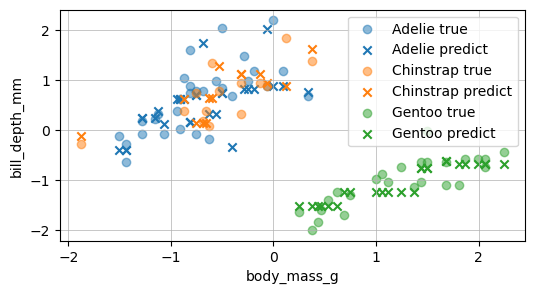

In [20]:
# print out some statistics of the tree
model = DecisionTreeRegressor(criterion="squared_error")
model.fit(X_train, Y_train)
print(f"full depth model has depth = {model.get_depth()} and {model.get_n_leaves()} leaves")
Y_pred = model.predict(X_test)
print(f"full depth model has MSE = {mean_squared_error(Y_pred, Y_test):.4f}")

model = DecisionTreeRegressor(ccp_alpha=0.001, criterion="squared_error")
model.fit(X_train, Y_train)
print(f"pruned model has depth = {model.get_depth()} and {model.get_n_leaves()} leaves")
Y_pred = model.predict(X_test)
print(f"pruned model has MSE = {mean_squared_error(Y_pred, Y_test):.4f}")

Y_pred = model.predict(X_test)

fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
for j in range(len(encoder.classes_)):
    ax.scatter(X_test[X_test[:, 1]==j, 0], Y_test[X_test[:, 1]==j],
               label=f"{encoder.classes_[j]} true",
               color=f"C{j}",
               alpha=0.5,  # fade this for demonstration later
               )
    ax.scatter(X_test[X_test[:, 1]==j, 0], Y_pred[X_test[:, 1]==j],
               label=f"{encoder.classes_[j]} predict",
               color=f"C{j}",
               marker="x",
               )
ax.set_xlabel(f"{target_vars[ind[0]]}")
ax.set_ylabel(f"{target_vars[ind[1]]}")
ax.grid(lw=0.5, zorder=0)
ax.legend();

> <span style="color:red">Q.</span> Try the case where you don't provide the `species` feature to see how bad/good the fitting is (it's probably bad if `max_depth` is low).
>
> <span style="color:red">Q.</span> Try increasing `max_depth` and see how variability in data is recovered, and quantify errors accordingly as a function of `max_depth`. You may want to fix the `random_state` values.
>
> Just a note that the plotting of the tree may be slow with increasing `max_depth`; you probably can't see anything in that case anyway, so probaby just avoid that plot command.
>
> <span style="color:red">Q.</span> Do the above but for `ccp_alpha` also. You may want to fix the `random_state` values.
>
> <span style="color:red">Q.</span> You can and should control over-fitting via other parameters that can be specified in the model initialisation, if one reason is to control the time it takes for the model to be trained. Have a look at what some of those are and try specifying those also.

----------------
# More involved exercises with this notebook

## 1) Decision trees with dimension reduction approaches

Consider doing a dimension reduction on the data first (e.g. PCA), and then fit a decision tree to that instead. Evaluate performance and dependence on parameters that control tree complexity.

## 2) Classifying cats and dogs

#### (This one is related to the upcoming assignment.) 

Try and do cats and dogs classification. You may or may not want to use dimension reduction approaches first.

You may also want to revisit again after all the subsequent lectures (random forests, neural networks), because it's a hard test in general.

## 3) Predicting cats and dogs

#### (This one is related to the upcoming assignment.) 

This one might be slow. Try and do cats and/or dog regression by predicting the right side of the face from the pixels on the left side, or top and bottom, or whatever really.

Consider how you may couple in dimensional reduction techniques here as well, which will really help with model training speed (because otherwise your feature dimensions are very large).

You may also want to revisit again after all the subsequent lectures (random forests, neural networks), because it's a hard test in general.

## 4) Time series forecasting

Consider regression on time series data like `elnino34_sst.data`, Lotka-Volterra, Lorenz, or similar.